# Appendix

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Perceptron
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
from scipy.stats import pointbiserialr

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Fannie Mae Multifamily Housing Data from: https://datadynamics.fanniemae.com/data-dynamics/#/downloadLoanData/Multifamily <br>
Data Definitions: https://capitalmarkets.fanniemae.com/media/5986/display <br>
General Multifamily info: https://capitalmarkets.fanniemae.com/credit-risk-transfer/multifamily-credit-risk-transfer/multifamily-loan-performance-data <br>
Using: Loan Performance Data Main File

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ADS 504 Group 3 Final Project/FNMA_MF_Loan_Performance_Data_202312.csv')
df.head()

<ipython-input-3-7917c9ac8d36>:1: DtypeWarning: Columns (12,26,29,34,35,36,37,38,39,40,46,49,51,53,54,55,56,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/ADS 504 Group 3 Final Project/FNMA_MF_Loan_Performance_Data_202312.csv')


,Loan Number,Acquisition Date,Note Date,Maturity Date at Acquisition,Loan Acquisition UPB,Amortization Type,Interest Type,Loan Product Type,Original UPB,Amortization Term,...,Prepayment Provision,Prepayment Provision End Date,Affordable Housing Type,MCIRT Deal ID,MCAS Deal ID,DUS Prepayment Outcomes,DUS Prepayment Segments,Loan Age,Green Bond Indicator,Social Bond Indicator
0,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,140296,2000-10-31,1985-07-16,2001-08-10,"$82,501.71",NaN,ARM,DUS,"$82,501.71",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140297,2000-10-31,1985-07-18,2001-08-10,"$548,872.98",NaN,ARM,DUS,"$548,872.98",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Initial Data Exploration

In [ ]:
#(rows, columns)
print(df.shape)

#column names and data types
print(df.info())


(4628626, 62)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628626 entries, 0 to 4628625
Data columns (total 62 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   Loan Number                            int64  
 1   Acquisition Date                       object 
 2   Note Date                              object 
 3   Maturity Date at Acquisition           object 
 4   Loan Acquisition UPB                   object 
 5   Amortization Type                      object 
 6   Interest Type                          object 
 7   Loan Product Type                      object 
 8   Original UPB                           object 
 9   Amortization Term                      float64
 10  Original Interest Rate                 float64
 11  Lien Position                          object 
 12  Transaction ID                         object 
 13  Issue Date                             object 
 14  Loan Acquisition LTV                

In [ ]:
### Checking for Duplicates
unique_loans = df['Loan Number'].unique()
print(len(unique_loans))

66487


There are 66,487 unique loans in the data showing duplication of the records.

In [ ]:
print("Reporting Max:", df['Reporting Period Date'].max())
print("Reporting Min:", df['Reporting Period Date'].min())
print("Acquisition Date Max:", df['Acquisition Date'].max())
print("Acquisition Date Min:", df['Acquisition Date'].min())


Reporting Max: 2023-12-01
Reporting Min: 2000-01-01
Acquisition Date Max: 2023-12-29
Acquisition Date Min: 2000-01-01


The reporting range of the report is month-end reporting from Jan 2000 through Dec 2023. With Properties that Fannie Mae acquired from beginning of Jan 2000 through the end of December 2023.


In [ ]:
df['Reporting Period Date'] = pd.to_datetime(df['Reporting Period Date'])
df_unique = df.loc[df.groupby('Loan Number')['Reporting Period Date'].idxmax()]
print(df_unique.shape)

(66487, 62)


In [ ]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66487 entries, 3 to 4628613
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Loan Number                            66487 non-null  int64         
 1   Acquisition Date                       66487 non-null  object        
 2   Note Date                              66487 non-null  object        
 3   Maturity Date at Acquisition           66487 non-null  object        
 4   Loan Acquisition UPB                   66487 non-null  object        
 5   Amortization Type                      66485 non-null  object        
 6   Interest Type                          66487 non-null  object        
 7   Loan Product Type                      66487 non-null  object        
 8   Original UPB                           66487 non-null  object        
 9   Amortization Term                      65447 non-null  float64  

### Transforming Data

#### Find Unique values and Handle Different Data Types

In [ ]:
#Dropping columns that should not be included based on domain knowledge
#They would not be avalable at the time of acquisitions
df_unique.drop(['Transaction ID ', 'Issue Date', 'I/O End Date', 'Liquidation/Prepayment Code', 'Liquidation/Prepayment Date',
         'Foreclosure Date', 'Credit Event Date', 'Foreclosure Value', 'Lifetime Net Credit Loss Amount', 'Default Amount',
         'Credit Event Type', 'Loan Active Property Count', 'UPB - Current', 'Delinquency UPB', 'Loan Payment Status',
         'SDQ Indicator', 'Most Recent Modification Date', 'Modification Indicator', 'Defeasance Date',
         'Prepayment Provision End Date', 'DUS Prepayment Outcomes', 'DUS Prepayment Segments', 'Loan Age'], axis=1, inplace=True)

df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66487 entries, 3 to 4628613
Data columns (total 39 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Loan Number                            66487 non-null  int64         
 1   Acquisition Date                       66487 non-null  object        
 2   Note Date                              66487 non-null  object        
 3   Maturity Date at Acquisition           66487 non-null  object        
 4   Loan Acquisition UPB                   66487 non-null  object        
 5   Amortization Type                      66485 non-null  object        
 6   Interest Type                          66487 non-null  object        
 7   Loan Product Type                      66487 non-null  object        
 8   Original UPB                           66487 non-null  object        
 9   Amortization Term                      65447 non-null  float64  

In [ ]:
# Creating New column to remove years/dates
# want to avoid predicting Economic events like 2008

# Convert 'Acquisition Date' and 'Note Date' to datetime objects
df_unique['Acquisition Date'] = pd.to_datetime(df_unique['Acquisition Date'])
df_unique['Note Date'] = pd.to_datetime(df_unique['Note Date'])

# Calculate the difference between the two dates
df_unique['Date Difference'] = (df_unique['Acquisition Date'] - df_unique['Note Date']).dt.days

# Display the result
print(df_unique[['Acquisition Date', 'Note Date', 'Date Difference']])


        Acquisition Date  Note Date  Date Difference
3             2000-10-31 1985-07-16             5586
7             2000-10-31 1985-07-18             5584
67            2000-01-01 1999-11-01               61
141           2000-01-01 1999-11-01               61
264           2000-01-01 1999-12-01               31
...                  ...        ...              ...
4628407       2018-01-25 2017-12-22               34
4628488       2018-09-28 2018-08-23               36
4628510       2020-01-30 2019-12-27               34
4628553       2020-01-30 2019-12-27               34
4628613       2021-02-25 2021-02-25                0

[66487 rows x 3 columns]


In [ ]:
### Year had NAN that were filled with MODE
# Convert 'Acquisition Date' to datetime format
df_unique['Acquisition Date'] = pd.to_datetime(df_unique['Acquisition Date'])

# Extract the year from 'Acquisition Date'
df_unique['Acquisition Year'] = df_unique['Acquisition Date'].dt.year

# Ensure 'Acquisition Year' is integer
df_unique['Acquisition Year'] = df_unique['Acquisition Year'].astype(int)

# Convert 'Year Built' to numeric, handling non-numeric values
df_unique['Year Built'] = pd.to_numeric(df_unique['Year Built'], errors='coerce')

# Fill missing values with the mode of 'Year Built'
year_built_mode = df_unique['Year Built'].mode()[0]
df_unique['Year Built'].fillna(year_built_mode, inplace=True)

# Calculate 'Age at Acquisition'
df_unique['Age at Acquisition'] = df_unique['Acquisition Year'] - df_unique['Year Built']

# Print the relevant columns
print(df_unique[['Acquisition Date', 'Year Built', 'Age at Acquisition']])

        Acquisition Date  Year Built  Age at Acquisition
3             2000-10-31      1972.0                28.0
7             2000-10-31      1972.0                28.0
67            2000-01-01      1985.0                15.0
141           2000-01-01      1985.0                15.0
264           2000-01-01      1964.0                36.0
...                  ...         ...                 ...
4628407       2018-01-25      1979.0                39.0
4628488       2018-09-28      1965.0                53.0
4628510       2020-01-30      1974.0                46.0
4628553       2020-01-30      1974.0                46.0
4628613       2021-02-25      1925.0                96.0

[66487 rows x 3 columns]


In [ ]:
# changing the MCIRT and MCAS deals to t/f

# Convert empty strings and None to NaN
df_unique['MCIRT Deal ID'].replace('', None, inplace=True)
df_unique['MCAS Deal ID'].replace('', None, inplace=True)

# convert columns to string
df_unique['MCIRT Deal ID'] = df_unique['MCIRT Deal ID'].astype(str)
df_unique['MCAS Deal ID'] = df_unique['MCAS Deal ID'].astype(str)

# boolean columns indicating the presence of values
df_unique['MCIRT Deal ID Present'] = df_unique['MCIRT Deal ID'].apply(lambda x: x not in [None, 'nan', ''])
df_unique['MCAS Deal ID Present'] = df_unique['MCAS Deal ID'].apply(lambda x: x not in [None, 'nan', ''])


In [ ]:
# Merging the special programs into one category since most loans are labeled as N or NAN.
# This is a newer data field, and programs come and go frequently
def is_special_program(row):
    # Combine Affordable Housing Type into a special program indicator
    affordable = row['Affordable Housing Type'] not in [None, '']
    # Combine Green Bond and Social Bond indicators
    green_bond = row['Green Bond Indicator'] == 'Y'
    social_bond = row['Social Bond Indicator'] == 'Y'

    return 'Y' if affordable or green_bond or social_bond else 'N'

# Apply the function to create a new column
df_unique['Special Program'] = df_unique.apply(is_special_program, axis=1)

#drop original columns in next step

In [ ]:
def categorize_prepayment_provision(value):
  if isinstance(value, str):
    if 'L' in value:
        return 'L'
    elif 'YM' in value:
        return 'YM'
    elif '%' in value:
        return 'Percent'
    elif 'DEF' in value:
        return 'DEF'
    elif 'O*' in value:
        return 'Open3'
    elif 'O' in value:
        return 'Open'
    else:
        return 'Other'  # Handling any values that do not fit into the defined categories
  else:
      return 'Other'  # Handling non-string values

# Apply the mapping function to the DataFrame
df_unique['Prepayment Provision Category'] = df_unique['Prepayment Provision'].apply(categorize_prepayment_provision)

# Optional: Drop the original 'Prepayment Provision' column if no longer needed
# df_unique = df_unique.drop(columns=['Prepayment Provision'])



#### Drop Features based on Domain Knowledge

In [ ]:
#Drop dates, Loan #, and extra location info
#drop 'Original I/O Term' because half the records were missing values
#drop 'Modified Loss Sharing Percentage' because most of the records are missing data
#drop sales price because most data was missing and get the same info from Loan Acquisition UPB & Underwritten DSCR
#drop Original UPB bc highly correlated to Loan Acquisition UPB
df_unique.drop(['Acquisition Date', 'Note Date', 'Year Built', 'Reporting Period Date', 'Loan Number',
                'Maturity Date at Acquisition', 'Acquisition Year', 'Property City', 'Property State',
                'Property Zip Code', 'Maturity Date - Current', 'Original I/O Term',
                'Modified Loss Sharing Percentage', 'Sale Price', 'Original UPB','Affordable Housing Type',
                'Green Bond Indicator', 'Social Bond Indicator', 'Prepayment Provision', 'Metropolitan Statistical Area'], axis=1, inplace=True)

df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66487 entries, 3 to 4628613
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Loan Acquisition UPB                   66487 non-null  object 
 1   Amortization Type                      66485 non-null  object 
 2   Interest Type                          66487 non-null  object 
 3   Loan Product Type                      66487 non-null  object 
 4   Amortization Term                      65447 non-null  float64
 5   Original Interest Rate                 66487 non-null  float64
 6   Lien Position                          66486 non-null  object 
 7   Loan Acquisition LTV                   66484 non-null  float64
 8   Underwritten DSCR                      66478 non-null  float64
 9   Underwritten DSCR Type                 66478 non-null  object 
 10  Original Term                          66487 non-null  int64  
 11  Loan 

In [ ]:
# Remove currency symbols and commas
df_unique['Loan Acquisition UPB'] = df_unique['Loan Acquisition UPB'].replace({'\$': '', ',': ''}, regex=True)

# Convert to float
df_unique['Loan Acquisition UPB'] = df_unique['Loan Acquisition UPB'].astype(float)

In [ ]:
df_unique.head()
df_unique.isna().sum()

,0
Loan Acquisition UPB,0
Amortization Type,2
Interest Type,0
Loan Product Type,0
Amortization Term,1040
Original Interest Rate,0
Lien Position,1
Loan Acquisition LTV,3
Underwritten DSCR,9
Underwritten DSCR Type,9


#### Handling Missing NAN Values

In [ ]:
# Cleanup NAN Values

#Amortization Type has 2 NAN
def fill_mode(series):
    mode = series.mode()
    if not mode.empty:
        return series.fillna(mode[0])
    else:
        return series

def fill_median(series, global_median):
    # Calculate the median for the series
    median = series.median()
    # If median is valid, fill missing values with it
    if pd.notna(median):
        return series.fillna(median)
    else:
        # If median is not valid, fill with the global median
        return series.fillna(global_median)

# Apply the function to fill missing values in 'Amortization Type' grouped by 'Interest Type'
df_unique['Amortization Type'] = df_unique.groupby('Interest Type')['Amortization Type'].transform(fill_mode)

#Amortization Term has 1040 NANs
# Apply the function to fill missing values in 'Amortization Term' grouped by 'Loan Product Type'
df_unique['Amortization Term'] = df_unique.groupby('Loan Product Type')['Amortization Term'].transform(fill_mode)

#lien position has 1 NAN filling with Mode
df_unique['Lien Position'].fillna(df_unique['Lien Position'].mode()[0], inplace=True)

#Loan Acquisition LTV has 3 NAN filling with Median due to heavy right skew
df_unique['Loan Acquisition LTV'].fillna(df_unique['Loan Acquisition LTV'].median(), inplace=True)

# Underwritten DSCR & Underwritten DSCR Type are heavily skewed and returning Medium and Mode
df_unique['Underwritten DSCR'].fillna(df_unique['Underwritten DSCR'].median(), inplace=True)
df_unique['Underwritten DSCR Type'].fillna(df_unique['Underwritten DSCR Type'].mode()[0], inplace=True)

# Loss Sharing Type has 2564 NAN filling with mode grouped by loan product type
def impute_mode(group):
    mode_value = group.mode()[0]  # Get the mode of the group
    return group.fillna(mode_value)

df_unique['Loss Sharing Type'] = df_unique.groupby('Loan Product Type')['Loss Sharing Type'].transform(impute_mode)

# Number of Properties at Acquisition & Property Acquisition Total Unit Count & Physical Occupancy %
# filling with median group by loan type
global_median = df_unique['Number of Properties at Acquisition'].median()
df_unique['Number of Properties at Acquisition'] = df_unique.groupby('Loan Product Type')['Number of Properties at Acquisition'].transform(
    lambda x: fill_median(x, global_median))
df_unique['Property Acquisition Total Unit Count'] = df_unique.groupby('Loan Product Type')['Property Acquisition Total Unit Count'].transform(
    lambda x: fill_median(x, global_median))
df_unique['Physical Occupancy %'] = df_unique.groupby('Loan Product Type')['Physical Occupancy %'].transform(
    lambda x: fill_median(x, global_median))

# Note Rate has 2 NAN filling with mean grouped by Interest type
df_unique['Note Rate'] = df_unique.groupby('Interest Type')['Note Rate'].transform(lambda x: x.fillna(x.mean()))


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
# Verify above logic
df_unique.isna().sum()

,0
Loan Acquisition UPB,0
Amortization Type,0
Interest Type,0
Loan Product Type,0
Amortization Term,0
Original Interest Rate,0
Lien Position,0
Loan Acquisition LTV,0
Underwritten DSCR,0
Underwritten DSCR Type,0


### Exploratory Data Analysis

In [ ]:
df_unique.shape

(66487, 26)

In [ ]:
# Summary Statistics of entire unique df
print("\nSummary statistics:")
summary_stats = df_unique.describe()
display(summary_stats)


Summary statistics:


,Loan Acquisition UPB,Amortization Term,Original Interest Rate,Loan Acquisition LTV,Underwritten DSCR,Original Term,Number of Properties at Acquisition,Property Acquisition Total Unit Count,Physical Occupancy %,Note Rate,Date Difference,Age at Acquisition
count,6.648700e+04,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000,66487.000000
mean,1.253142e+07,304.238167,4.823674,64.673790,1.757384,125.544257,1.031344,160.271421,89.190800,4.867519,31.667213,35.137952
std,2.377555e+07,128.689564,1.260500,14.207045,1.522877,48.015747,0.935104,179.891703,20.431779,1.287385,47.432683,24.845559
min,1.144005e+04,0.000000,1.222000,0.000000,0.390000,11.000000,1.000000,1.000000,0.000000,0.552000,-30.000000,-1.000000
25%,2.580000e+06,360.000000,3.920000,58.100000,1.280000,120.000000,1.000000,56.000000,92.000000,3.950000,24.000000,18.000000
50%,6.071000e+06,360.000000,4.750000,66.900000,1.420000,120.000000,1.000000,122.000000,95.000000,4.765000,30.000000,33.000000
75%,1.420000e+07,360.000000,5.710000,75.000000,1.790000,120.000000,1.000000,224.000000,95.000000,5.740000,37.000000,47.000000
max,9.514950e+08,540.000000,9.800000,276.200000,85.720000,480.000000,105.000000,11246.000000,100.000000,11.570000,5586.000000,219.000000


In [ ]:
# Separate categorical and numeric data for EDA
numeric_df = df_unique.select_dtypes(include=['float64', 'int64', 'bool'])
categorical_df = df_unique.select_dtypes(include=['object'])

In [ ]:
# Check the distribution of the target variable
if 'Loan Ever 60+ Days Delinquent' in df.columns:
    print("\nDistribution of the target variable:")
    value_counts = df_unique['Loan Ever 60+ Days Delinquent'].value_counts()
    print(value_counts)


Distribution of the target variable:
Loan Ever 60+ Days Delinquent
N    64727
Y     1760
Name: count, dtype: int64


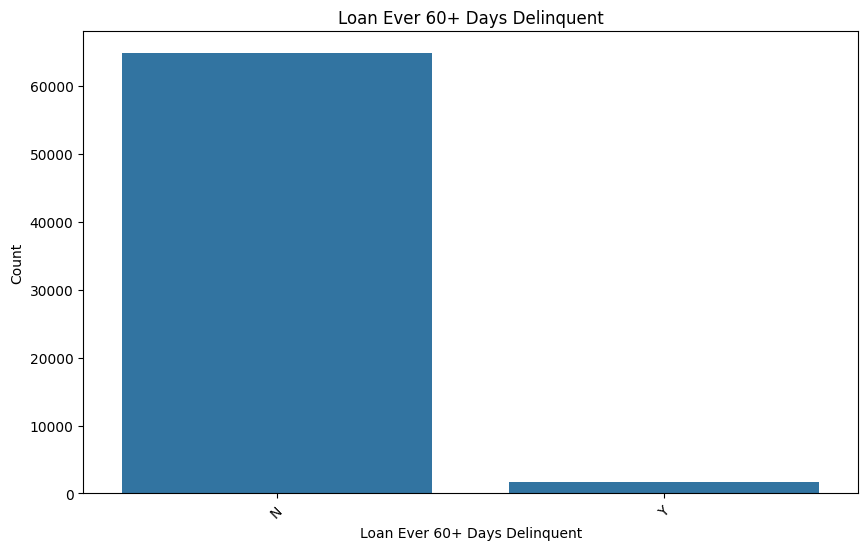

In [ ]:
# Convert value_counts to DataFrame for better handling with Seaborn
target_counts_df = value_counts.reset_index()
target_counts_df.columns = ['Loan Ever 60+ Days Delinquent', 'count']

# Plotting the distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=target_counts_df, x='Loan Ever 60+ Days Delinquent', y='count')
plt.title('Loan Ever 60+ Days Delinquent')
plt.xlabel('Loan Ever 60+ Days Delinquent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

There is a significant inbalance in the target variable that will have to be balanced using SMOTE in the preprocessing stages of the pipeline further on in the analysis.

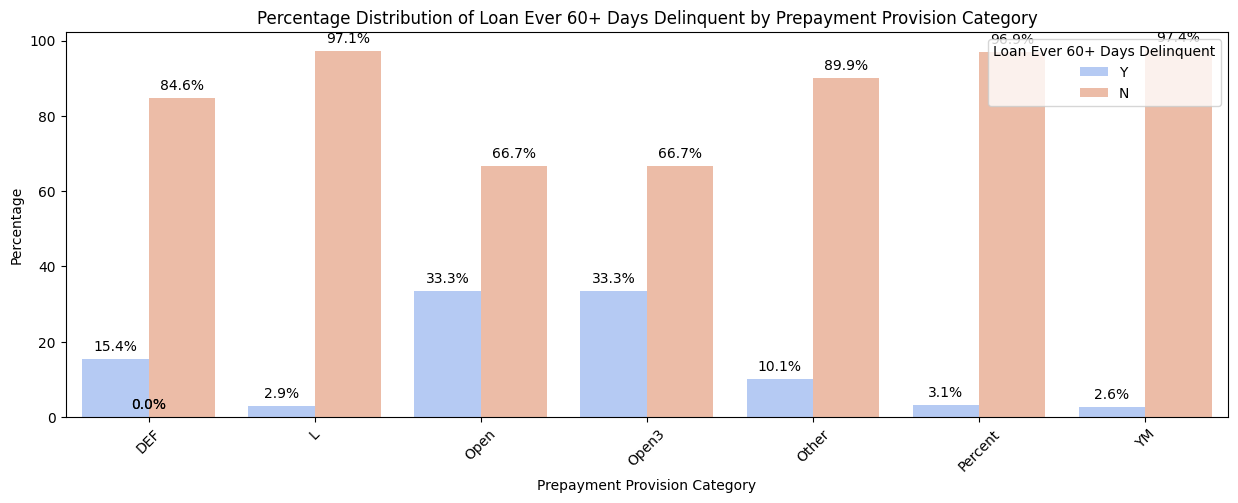

In [ ]:
# Distribution of target variable by prepayment provision category feature
plt.figure(figsize=(15, 5))
# Calculate counts
count_data = df_unique.groupby(['Prepayment Provision Category', 'Loan Ever 60+ Days Delinquent']).size().unstack().fillna(0)

# Calculate percentages
percentage_data = count_data.div(count_data.sum(axis=1), axis=0) * 100

# Reset index for plotting
percentage_data = percentage_data.reset_index()
# Melt the DataFrame for seaborn compatibility
melted_percentage_data = percentage_data.melt(id_vars='Prepayment Provision Category',
                                              value_vars=['Y', 'N'],
                                              var_name='Loan Ever 60+ Days Delinquent',
                                              value_name='Percentage')

# Create a bar plot
sns.barplot(data=melted_percentage_data, x='Prepayment Provision Category', y='Percentage', hue='Loan Ever 60+ Days Delinquent', palette='coolwarm')

# Add labels and title
plt.title('Percentage Distribution of Loan Ever 60+ Days Delinquent by Prepayment Provision Category')
plt.xlabel('Prepayment Provision Category')
plt.ylabel('Percentage')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend(title='Loan Ever 60+ Days Delinquent', loc='upper right')

# Add percentage labels on bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.1f}%',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center',
                       va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points')

plt.show()

#### Distribution of Features


Histograms for numerical features:


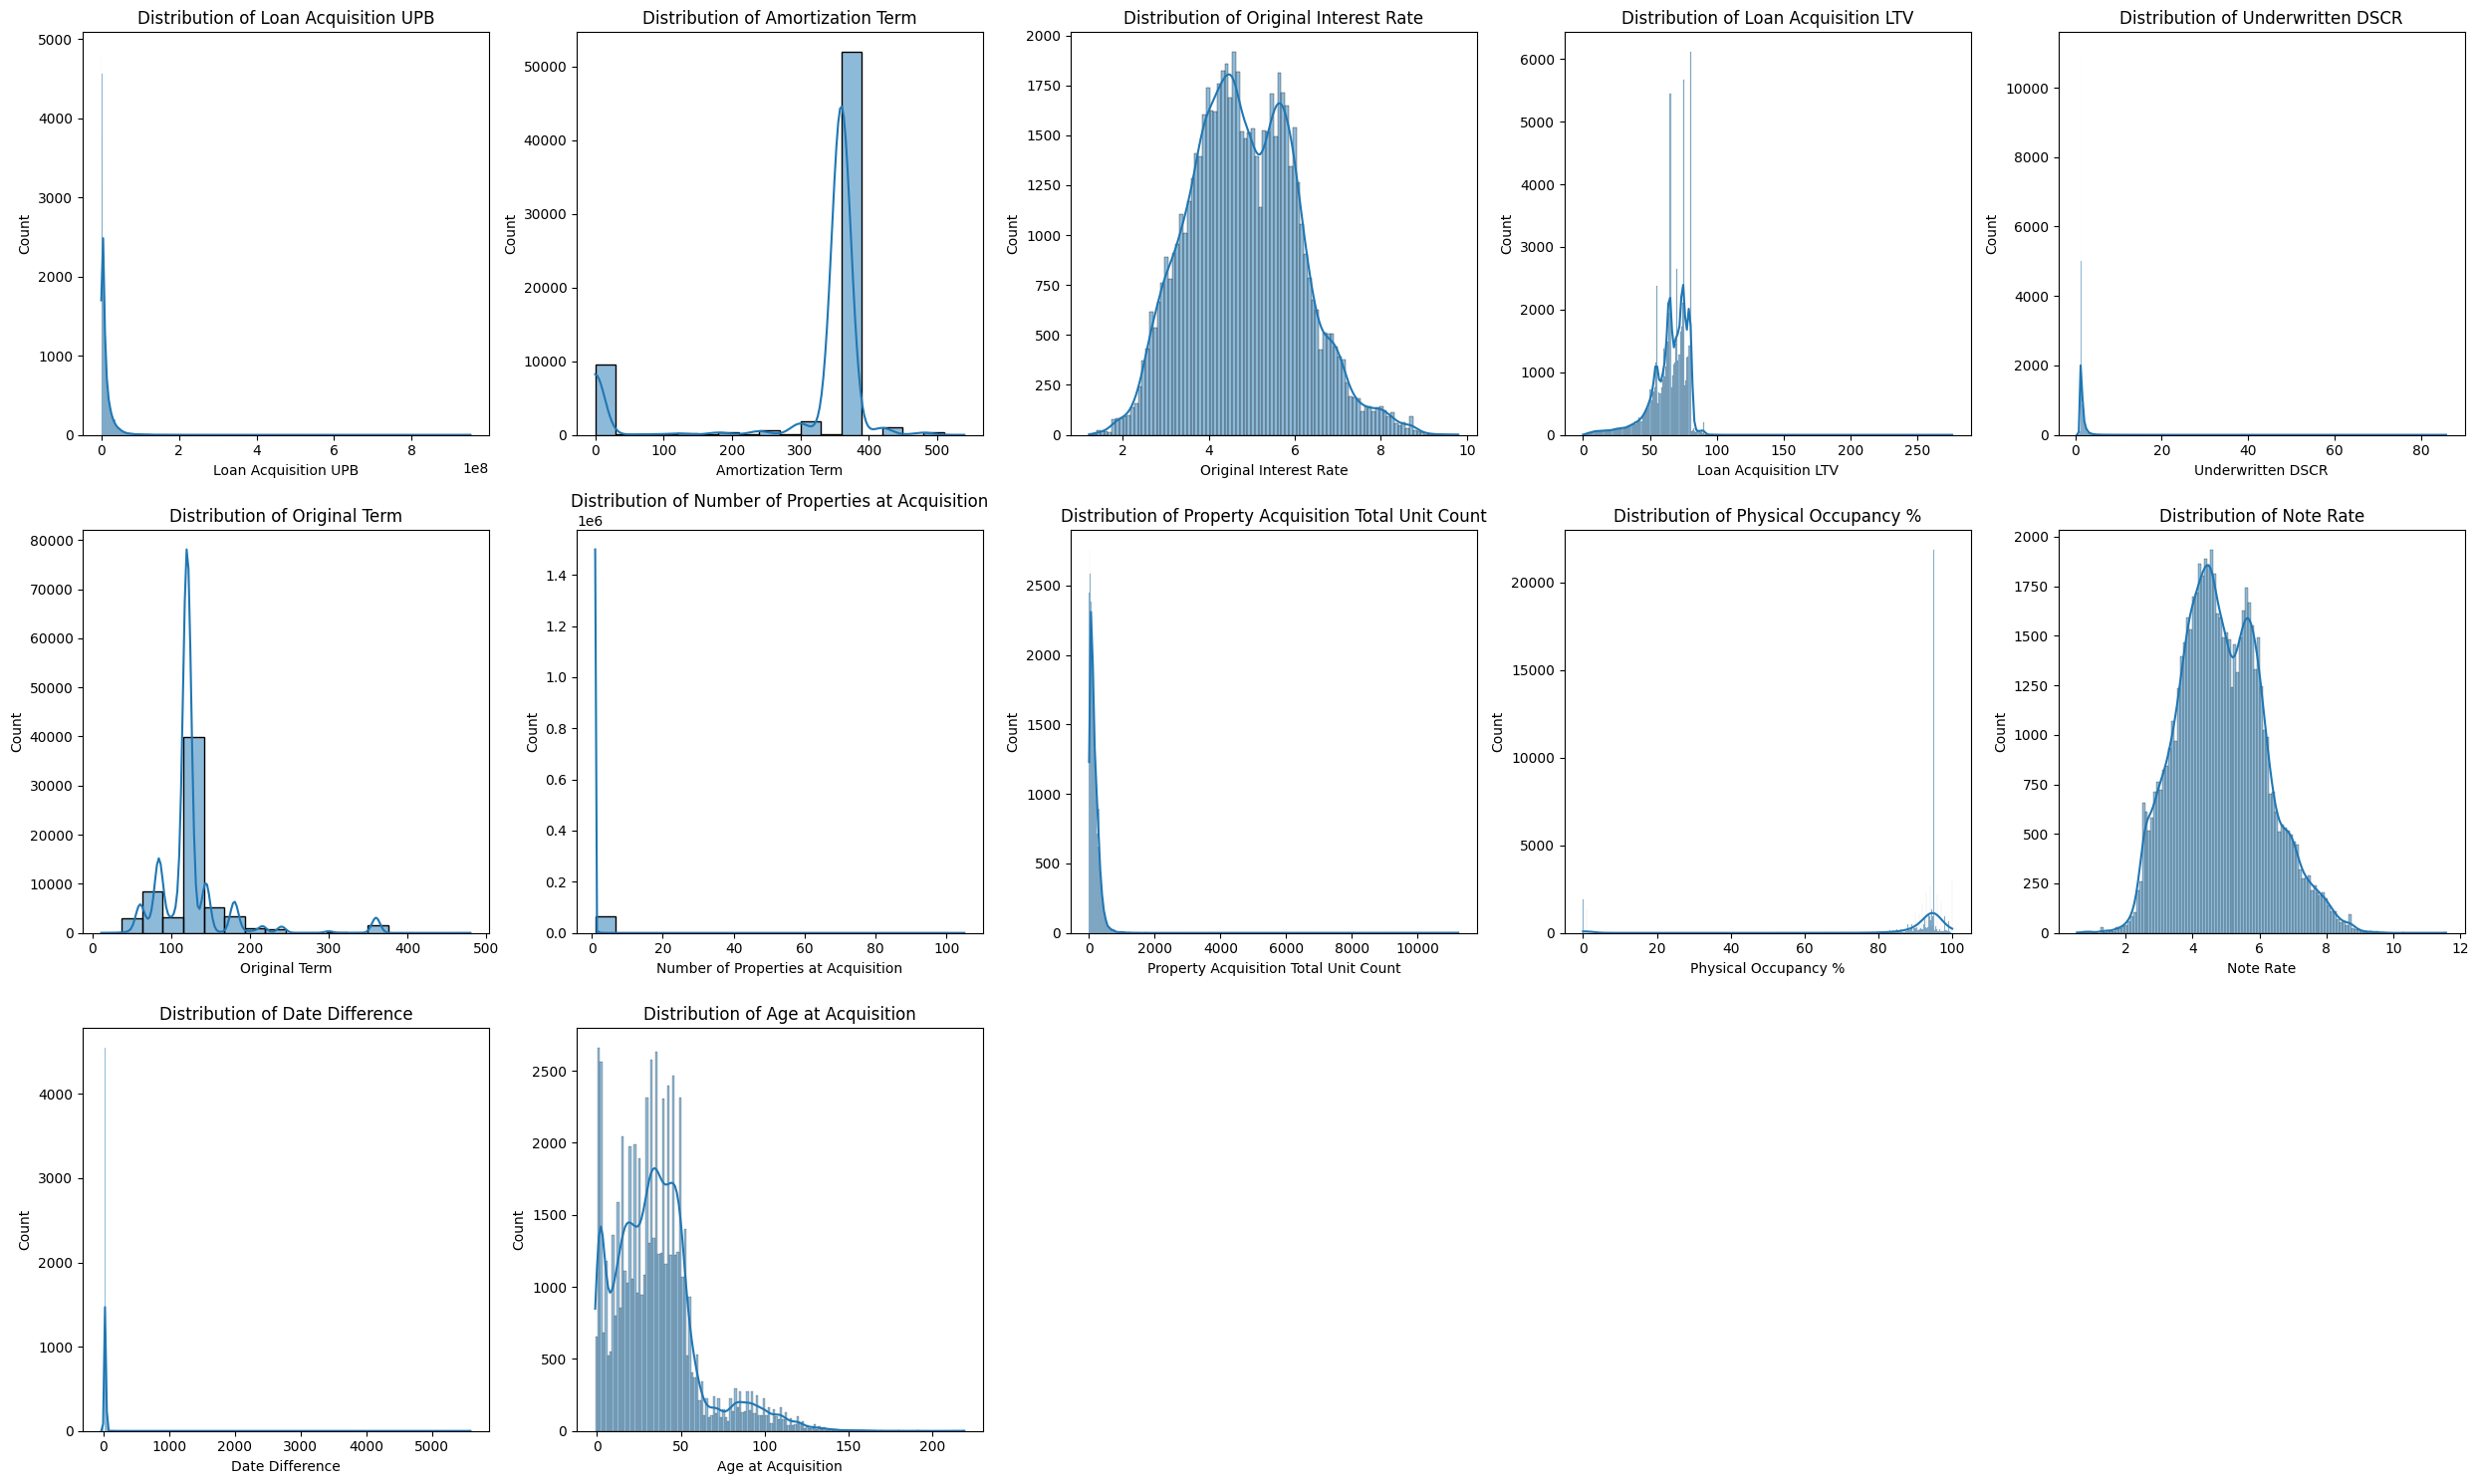

In [ ]:
# Distribution (Historgram) of Numeric Features
print("\nHistograms for numerical features:")
numerical_features = df_unique.select_dtypes(include=[np.number]).columns.tolist()

# Define the number of plots per row
plots_per_row = 5
num_features = len(numerical_features)
num_rows = (num_features // plots_per_row) + int(num_features % plots_per_row != 0)

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df_unique[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

There are numeric variables that will need to be standardized in the preproccesing pipeline of the models.

In [ ]:
# Get frequency counts for each categorical column
frequency_counts = categorical_df.apply(lambda x: x.value_counts()).stack().reset_index()
frequency_counts.columns = ['variable', 'value', 'count']

# Convert 'count' to numeric if it's not already
frequency_counts['count'] = pd.to_numeric(frequency_counts['count'], errors='coerce')

# Sort the frequency counts table
frequency_counts = frequency_counts.sort_values(by=['variable', 'count'], ascending=[True, False])

# Print the frequency counts table using tabulate
print(tabulate(frequency_counts, headers='keys', tablefmt='psql'))

+----+----------------------------------+-------------------------------+---------+
|    | variable                         | value                         |   count |
|----+----------------------------------+-------------------------------+---------|
|  0 | ARM                              | Interest Type                 |    5862 |
|  1 | Amortizing Balloon               | Amortization Type             |   31949 |
|  2 | Bulk Delivery                    | Loan Product Type             |     374 |
|  3 | Cooperative                      | Specific Property Type        |    1881 |
|  4 | Credit Facility                  | Loan Product Type             |    1322 |
|  5 | DEF                              | Prepayment Provision Category |      13 |
|  6 | DUS                              | Loan Product Type             |   62826 |
|  7 | Deal UW DSCR NCF                 | Underwritten DSCR Type        |     740 |
|  8 | Dedicated Student                | Specific Property Type        |   

#### Correlations

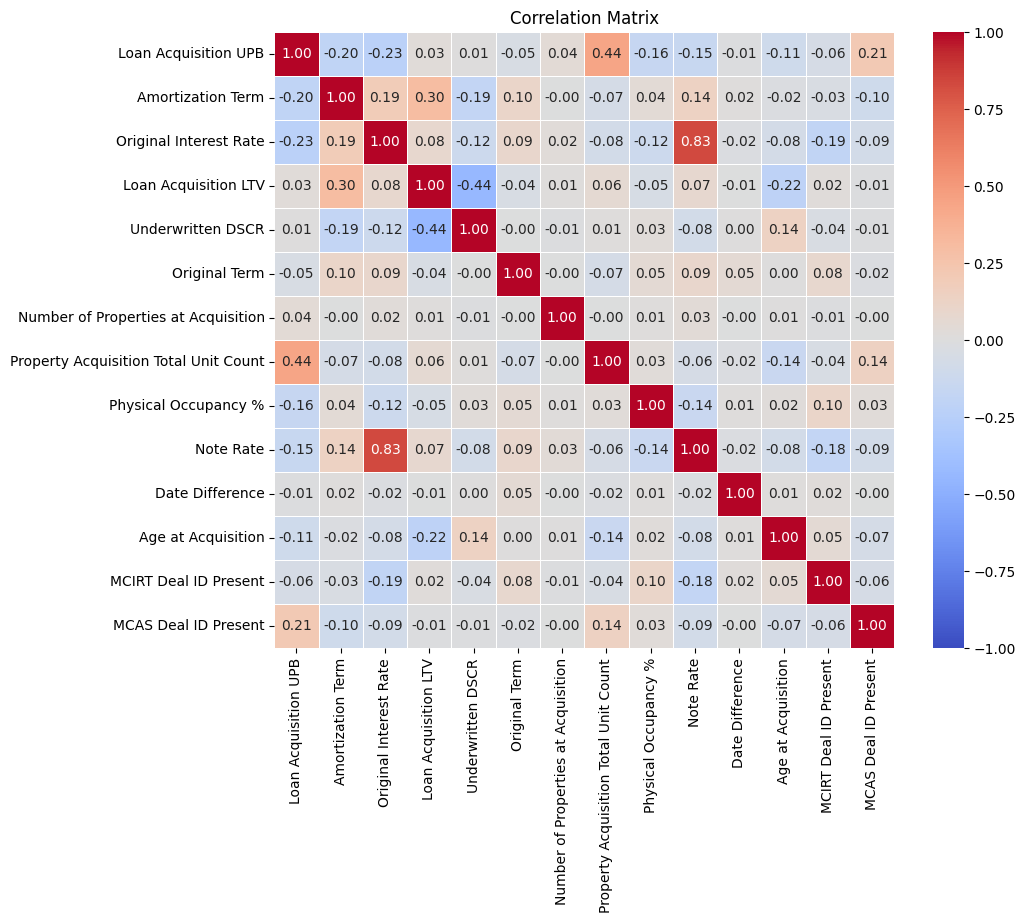

In [ ]:
# Calculate the correlation matrix of numeric variables
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Correlation of numeric features to target

# Convert 'Y'/'N' in the target variable to 1/0
df_unique['Loan Ever 60+ Days Delinquent'] = df_unique['Loan Ever 60+ Days Delinquent'].map({'Y': 1, 'N': 0})

# Drop rows where the target variable is NaN
df_unique = df_unique.dropna(subset=['Loan Ever 60+ Days Delinquent'])

# Ensure all numerical features are actually numeric
numerical_features = df_unique.select_dtypes(include=[np.number]).columns.tolist()

# Additional check to ensure there are no non-numeric entries in numerical features
for feature in numerical_features:
    if feature != 'Loan Ever 60+ Days Delinquent':
        df_unique[feature] = pd.to_numeric(df_unique[feature], errors='coerce')

# Drop rows where any numerical feature is NaN after conversion
df_unique = df_unique.dropna(subset=numerical_features)

# Calculate point biserial correlation for numerical features
correlations = {}
for feature in numerical_features:
    if feature != 'Loan Ever 60+ Days Delinquent':
        corr,_ = pointbiserialr(df_unique[feature], df_unique['Loan Ever 60+ Days Delinquent'])
        correlations[feature] = corr

# Convert the correlations to a DataFrame for better visualization
correlations_df = pd.DataFrame(correlations.items(), columns=['Feature', 'Correlation'])
print(correlations_df)

                                  Feature  Correlation
0                    Loan Acquisition UPB    -0.028789
1                       Amortization Term     0.059474
2                  Original Interest Rate     0.101287
3                    Loan Acquisition LTV     0.089547
4                       Underwritten DSCR    -0.033349
5                           Original Term     0.007612
6     Number of Properties at Acquisition     0.001286
7   Property Acquisition Total Unit Count    -0.020977
8                    Physical Occupancy %    -0.010266
9                               Note Rate     0.092650
10                        Date Difference     0.028838
11                     Age at Acquisition     0.007437


Highly correlated variables note rate and original interest rate have similar correlations to the target variable. Knowing this, we will remove the note rate feature in order to avoid multicollinearity and still represent the feature properly with original interest rate.

In [ ]:
# Remove Note Rate
df_unique = df_unique.drop(columns=['Note Rate'])

In [ ]:
# Correlation of categorical features to target

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = df_unique.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

# Calculate Cramer's V (chi-square) for categorical features
correlations = {}
for feature in categorical_features:
    if feature != 'Loan Ever 60+ Days Delinquent':
        # Create a contingency table
        confusion_matrix = pd.crosstab(df_unique[feature], df['Loan Ever 60+ Days Delinquent'])
        # Calculate Cramer's V
        correlations[feature] = cramers_v(confusion_matrix.to_numpy())

# Convert the correlations to a DataFrame for better visualization
correlations_df = pd.DataFrame(correlations.items(), columns=['Feature', 'Cramér\'s V'])
print(correlations_df)

                          Feature  Cramér's V
0               Amortization Type    0.068875
1                   Interest Type    0.006411
2               Loan Product Type    0.018170
3                   Lien Position    0.014070
4          Underwritten DSCR Type    0.093507
5               Loss Sharing Type    0.033063
6          Specific Property Type    0.070986
7                   MCIRT Deal ID    0.038203
8                    MCAS Deal ID    0.014750
9           MCIRT Deal ID Present    0.034219
10           MCAS Deal ID Present    0.014743
11                Special Program         NaN
12  Prepayment Provision Category    0.037879


<ipython-input-31-cc25151ac21d>:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


There are not strong enough correlations in either the categorical or numeric data to determine which features would be best to include in models. As the team has already removed unnecessary features based on domain knowledge and timelines of data, it is within the scope to include all remaining features in model training. Ultimately, the team will determine the top performing features upon model completion.

#### Outliers


Box plots for numeric features:


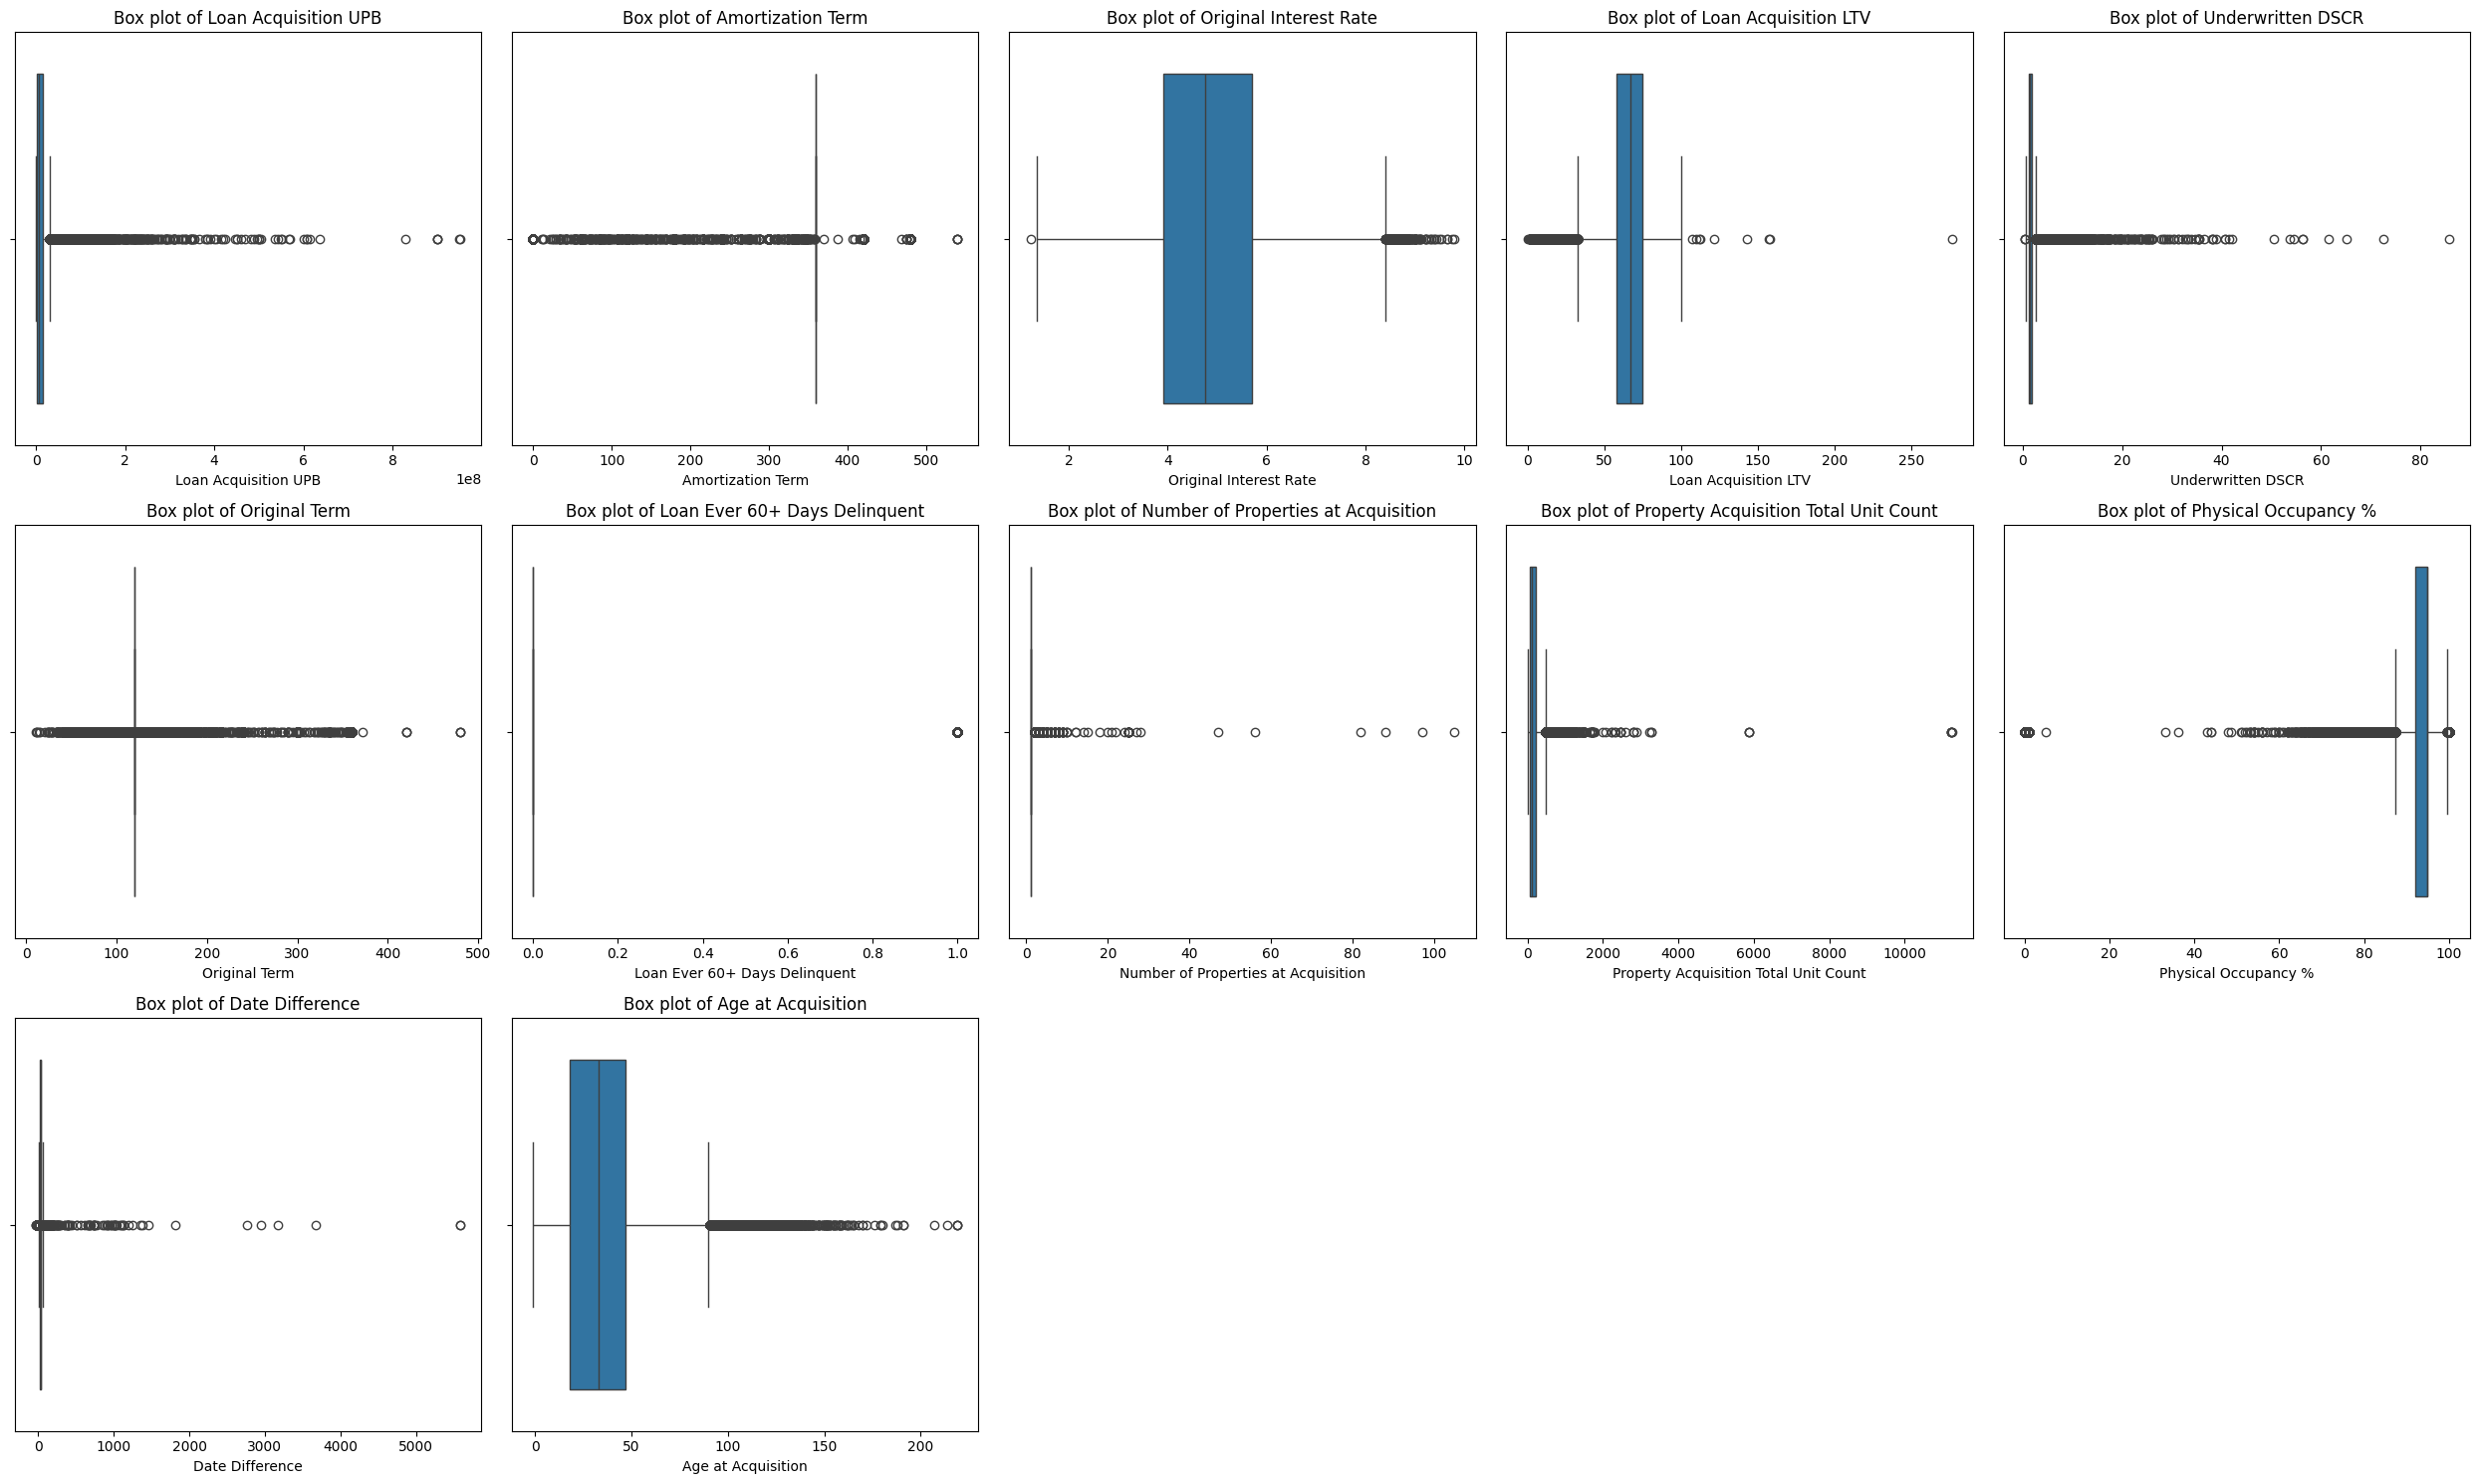

In [ ]:
# Check for outliers in numeric data
print("\nBox plots for numeric features:")
numerical_features = df_unique.select_dtypes(include=[np.number]).columns.tolist()

# Define the number of plots per row
plots_per_row = 5
num_features = len(numerical_features)
num_rows = (num_features // plots_per_row) + int(num_features % plots_per_row != 0)

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df_unique[feature], ax=axes[i])
    axes[i].set_title(f'Box plot of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save the figure as a .jpeg file
plt.savefig('/content/drive/MyDrive/outliers.jpeg', format='jpeg', dpi=300)
plt.show()

In [ ]:
# Handle outliers in numeric features with Z score

# Define the target feature in order to not change it with z-score calculation
target_feature = 'Loan Ever 60+ Days Delinquent'

# List of numerical features excluding the target feature
numerical_features = df_unique.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove(target_feature)  # Remove the target feature

# Calculate Z-scores for each numeric feature
z_scores = pd.DataFrame()
for feature in numerical_features:
    z_scores[feature] = stats.zscore(df_unique[feature].dropna())

# Define a threshold for Z-scores
threshold = 3

# Identify outliers based on Z-scores
outliers = (z_scores.abs() > threshold).any(axis=1)

# Filter out rows with outliers
df_final = df_unique[~outliers]

print(f"Original dataset shape: {df_unique.shape}")
print(f"Dataset shape after removing outliers: {df_final.shape}")

Original dataset shape: (66487, 25)
Dataset shape after removing outliers: (58325, 25)



Box plots for numeric features after outlier removal:


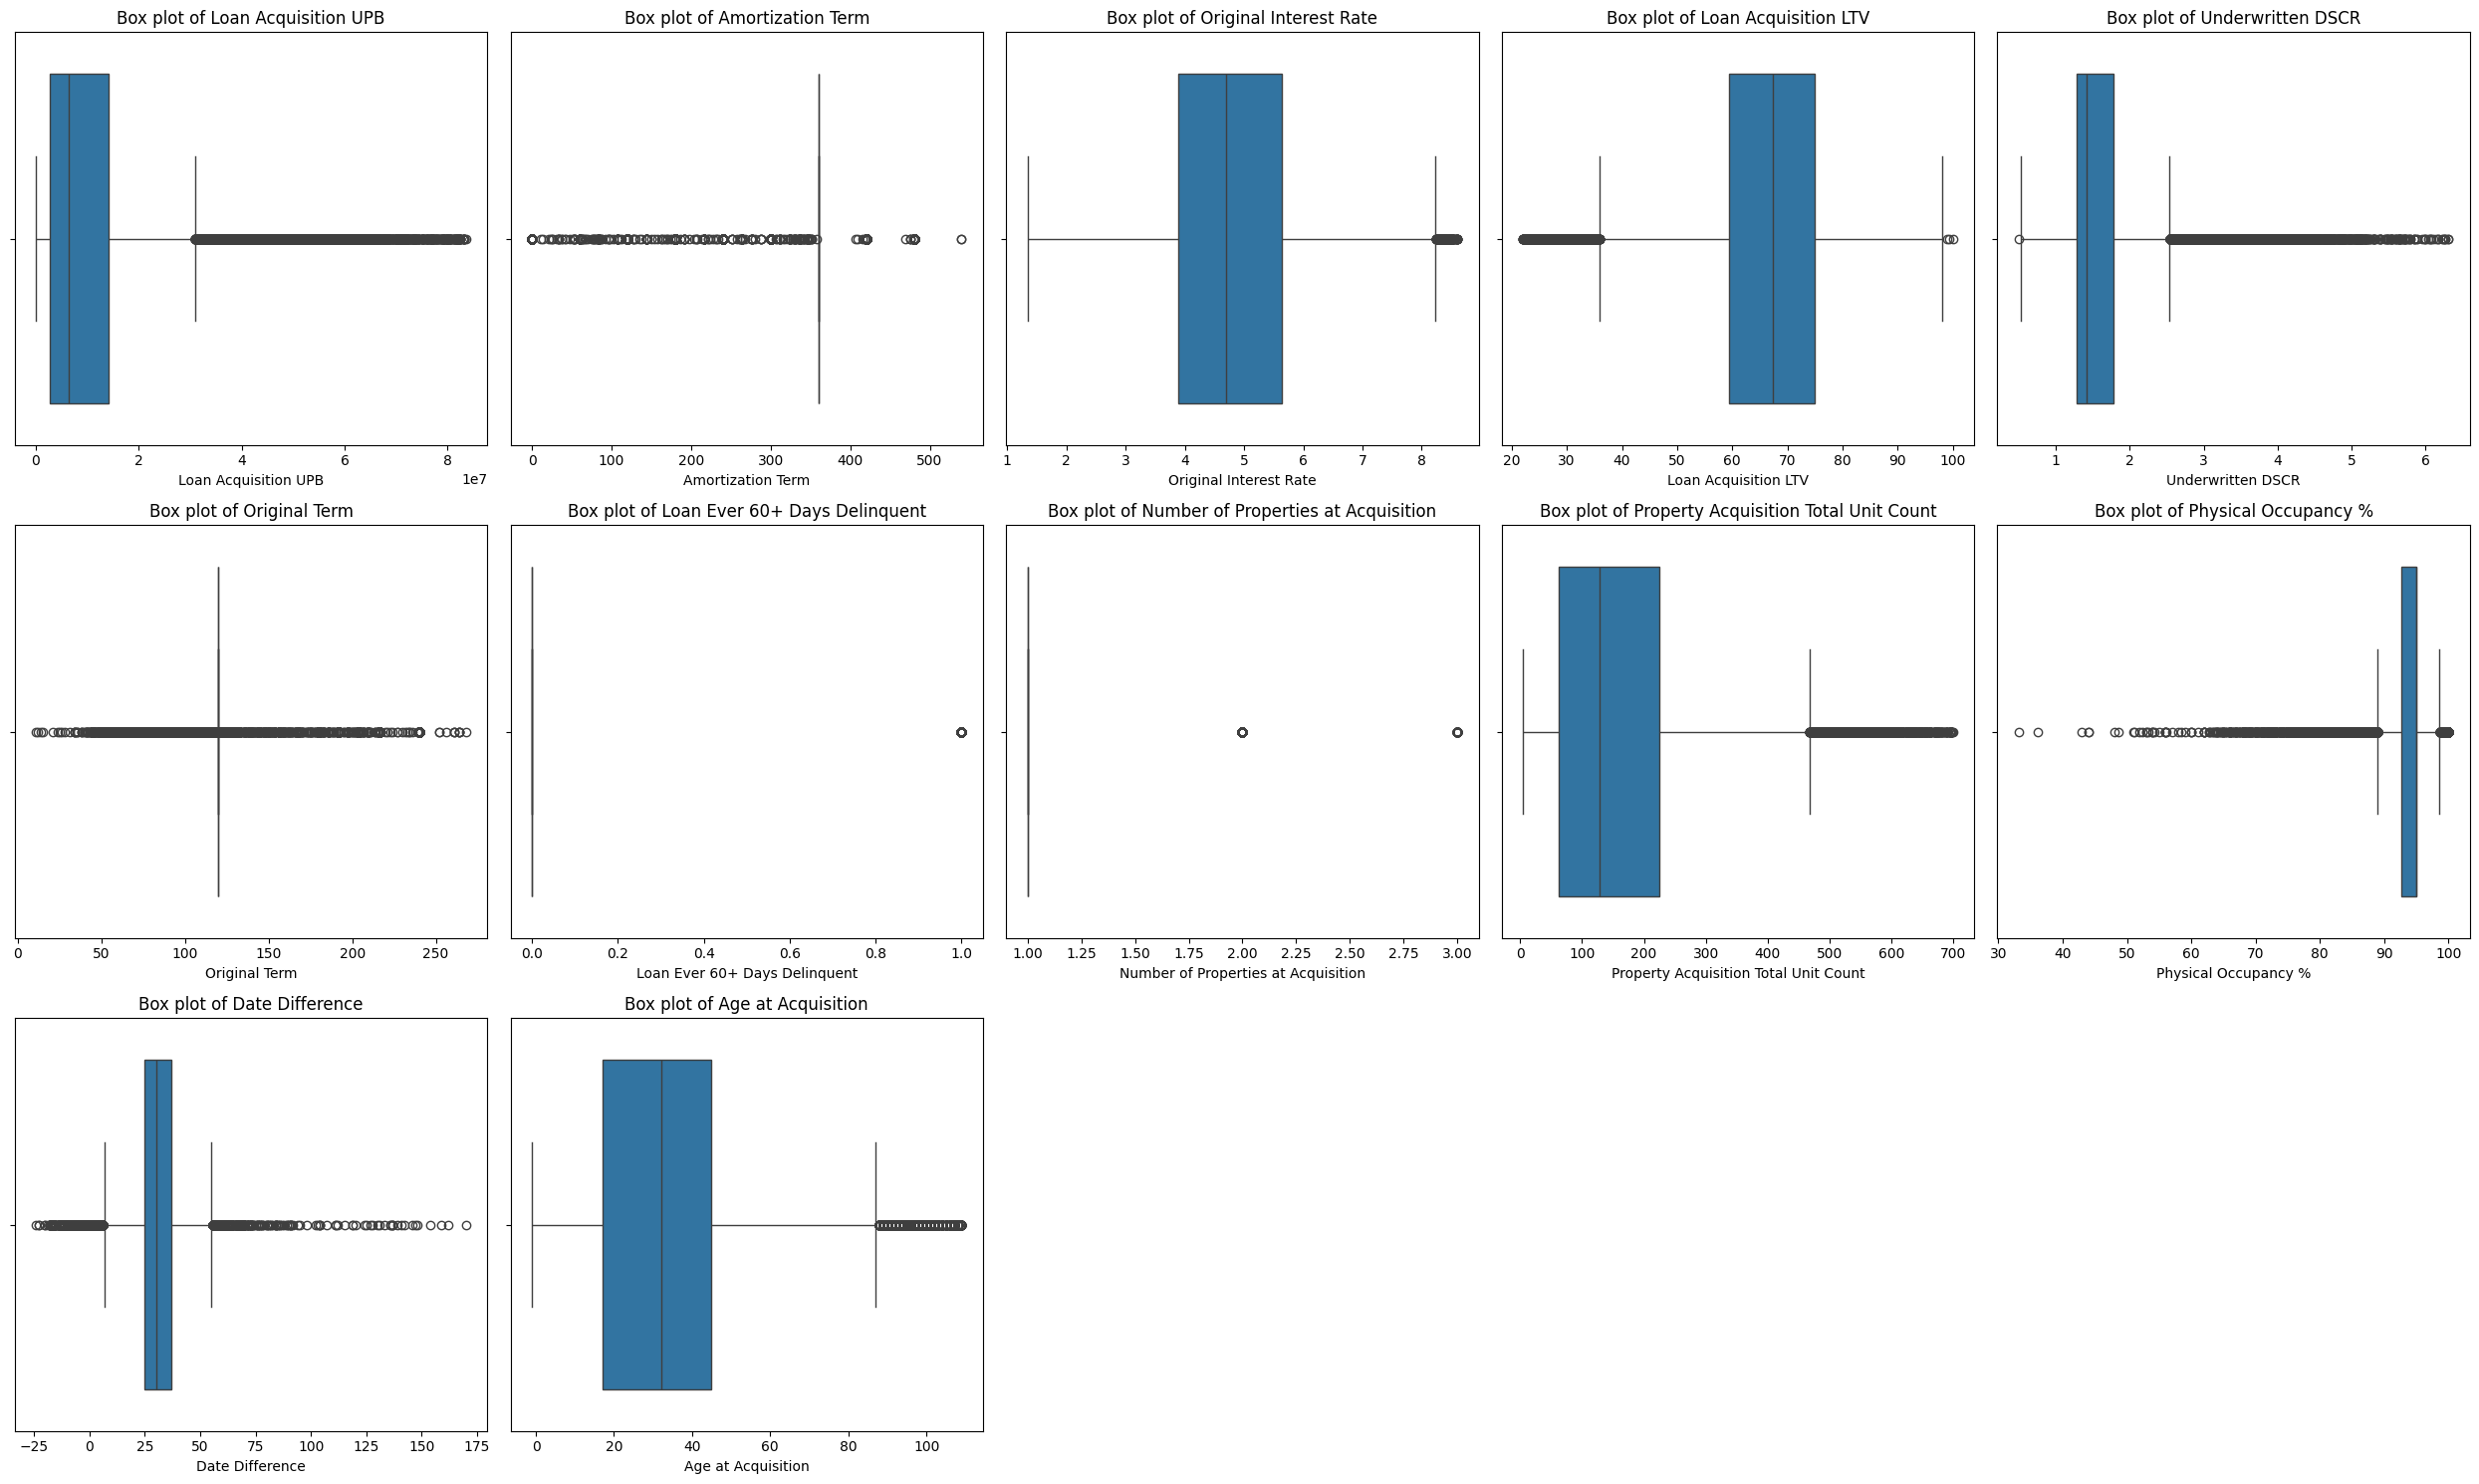

In [ ]:
# Validate outlier removal AFTER z-scores
# Check for outliers in numeric data
print("\nBox plots for numeric features after outlier removal:")
numerical_features = df_final.select_dtypes(include=[np.number]).columns.tolist()

# Define the number of plots per row
plots_per_row = 5
num_features = len(numerical_features)
num_rows = (num_features // plots_per_row) + int(num_features % plots_per_row != 0)

fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df_final[feature], ax=axes[i])
    axes[i].set_title(f'Box plot of {feature}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Model Preparation

Train/Test Split

In [ ]:
# Define the target variable column name
target_column = 'Loan Ever 60+ Days Delinquent'

# Separate features and target variable
X = df_final.drop(target_column,  axis=1)
y = df_final[target_column]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final pipeline with preprocessor, SMOTE, and classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)), # Balance Target Feature
    ('classifier', LogisticRegression(max_iter=1000))
])

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [ ]:
# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = pipeline.predict(X_train)

# Model Evaluation
y_pred = pipeline.predict(X_test)

# Print training set
print("Training Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

# Print test set
print("\nTest Set Performance:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get feature names AFTER preprocessing
# Fit the preprocessor on the training data
preprocessor.fit(X_train)

# Transform the training data to get the feature names after preprocessing
feature_names_transformed = preprocessor.get_feature_names_out()

# Access the LogisticRegression model within the pipeline
logistic_model = pipeline.named_steps['classifier']

# Create a DataFrame to view feature importance
coefficients = logistic_model.coef_[0] #Extract coefficients from the logistic regression model
feature_importance = pd.DataFrame({
    'Feature': feature_names_transformed,
    'Coefficient': coefficients
})

# Sort features by the coefficients
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Print top 10 features
print("\nTop 10 Features:")
print(feature_importance.head(10))

Training Set Performance:
Confusion Matrix:
[[32363 13068]
 [  300   929]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     45431
           1       0.07      0.76      0.12      1229

    accuracy                           0.71     46660
   macro avg       0.53      0.73      0.48     46660
weighted avg       0.97      0.71      0.81     46660


Test Set Performance:
Confusion Matrix:
[[8015 3343]
 [  67  240]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.82     11358
           1       0.07      0.78      0.12       307

    accuracy                           0.71     11665
   macro avg       0.53      0.74      0.47     11665
weighted avg       0.97      0.71      0.81     11665


Top 10 Features:
                                          Feature  Coefficient
40            cat__Specific Property Type_Seniors     2.356700
34  cat__Spec

In [ ]:
# Define the parameter grid for logistic regression
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[8030 3328]
 [  66  241]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11358
           1       0.07      0.79      0.12       307

    accuracy                           0.71     11665
   macro avg       0.53      0.75      0.47     11665
weighted avg       0.97      0.71      0.81     11665



### Modeling

In [ ]:
# Initialize a dictionary to hold metrics
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'CV Mean F1 Score': []}

# Define the models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC()
}

# Create a function to build pipelines for each model
def create_pipeline(model):
    return ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Results for {name}:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("\n")

     # Extract classification report metrics
    report = classification_report(y_test, y_pred, output_dict=True)

    # Collect metrics
    metrics['Model'].append(name)
    metrics['Accuracy'].append(report['accuracy'])
    metrics['Precision'].append(report['macro avg']['precision'])
    metrics['Recall'].append(report['macro avg']['recall'])
    metrics['F1 Score'].append(report['macro avg']['f1-score'])

    # Perform cross-validation and collect mean F1 score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_macro')
    metrics['CV Mean F1 Score'].append(cv_scores.mean())


Training Logistic Regression...
Results for Logistic Regression:
[[8015 3343]
 [  67  240]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.82     11358
           1       0.07      0.78      0.12       307

    accuracy                           0.71     11665
   macro avg       0.53      0.74      0.47     11665
weighted avg       0.97      0.71      0.81     11665



Training KNN...
Results for KNN:
[[10157  1201]
 [  169   138]]
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     11358
           1       0.10      0.45      0.17       307

    accuracy                           0.88     11665
   macro avg       0.54      0.67      0.55     11665
weighted avg       0.96      0.88      0.92     11665



Training SVM...
Results for SVM:
[[9316 2042]
 [ 102  205]]
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     11358
           1     

#### Extract metrics for all models

In [ ]:
# Convert the metrics dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)

# Print a clean table using tabulate
print("Model Comparison Metrics:")
print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))

Model Comparison Metrics:
+---+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
|   |        Model        |      Accuracy      |     Precision      |       Recall       |      F1 Score       |  CV Mean F1 Score   |
+---+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
| 0 | Logistic Regression | 0.7076725246463781 | 0.5293464739697475 | 0.7437144849904185 | 0.47399089678081396 | 0.40369748858948373 |
| 1 |         KNN         | 0.8825546506643807 | 0.5433477664724456 | 0.6718854766948119 | 0.5522494986532505  | 0.49179508249090775 |
| 2 |         SVM         | 0.8162023146163737 | 0.5402012149372046 | 0.7439836347753568 | 0.5286682513315014  |  0.483589250530267  |
+---+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+


In [ ]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install nbconvert

In [ ]:
%shell jupyter nbconvert --to pdf '/content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_FinalProject.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_FinalProject.ipynb to pdf
[NbConvertApp] Support files will be in Group3_FinalProject_files/
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Making directory ./Group3_FinalProject_files
[NbConvertApp] Writing 145000 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 787126 bytes to /content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_Fina

In [ ]:
%shell jupyter nbconvert --to html '/content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_FinalProject.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_FinalProject.ipynb to html
[NbConvertApp] Writing 1782920 bytes to /content/drive/MyDrive/ADS 504 Group 3 Final Project/Group3_FinalProject.html
